# Draw Networks for positive genes in RNA-seq data

## 0. import libraries

In [1]:
require(edgeR)
require(clusterProfiler)
require(enrichplot)
require(biomaRt)
require(DOSE)
require(org.Mm.eg.db)

Loading required package: edgeR

Loading required package: limma

Loading required package: clusterProfiler



clusterProfiler v3.16.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


Loading required package: enrichplot

Loading required package: biomaRt

Loading required package: DOSE

DOSE v3.14.0  For help: https://guangchuangyu.github.io/software/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Loading required p

## 1. analyze count matrix

### 1-1. identification of positive genes (RNA-seq解析フォーマットより)

In [2]:
# import data frame
selected_samples <- c("Y1","Y2","Y3","Y4",
                      "AWC2","AWC3","AWC4","AWC5")
e <- read.csv("count.csv",as.is=T,row=1)
e <- e[,selected_samples]
group<-c(rep("group1",4),rep("group2",4))
names(group)<-colnames(e)
Group1 = "Y1"
Group2 = "AWC"
group<-sort(group)
e<-e[,names(group)]

# remove genes with low expression
data <- e
obj <- as.logical(rowSums(data) > 0)
data <- unique(data[obj,])
data_jokyo <- data

#DEG
param_G1 <- sum(group=="group1")
param_G2 <- sum(group=="group2")
param_FDR <- 0.005
data <- data_jokyo
data.cl <- c(rep(1, param_G1), rep(2, param_G2))
d <- DGEList(counts=data,group=data.cl)
d <- calcNormFactors(d)
norm.factors <- d$samples$norm.factors/mean(d$samples$norm.factors)
ef.libsizes <- colSums(data)*norm.factors
normalized.count <- sweep(data, 2, mean(ef.libsizes)/ef.libsizes, "*")
d <- estimateCommonDisp(d) 
d <- estimateTagwiseDisp(d)
out <- exactTest(d)
p.value <- out$table$PValue
q.value <- p.adjust(p.value, method="BH")
logFC <- out$table$logFC
FC <- 2^logFC
ranking <- rank(p.value)
tmp <- cbind(rownames(data), normalized.count, p.value, q.value,logFC,FC,ranking)
upDEG <- rownames(tmp[which((tmp$p.value < param_FDR) & (tmp$FC > 1)),])
downDEG <- rownames(tmp[which((tmp$p.value < param_FDR) & (tmp$FC < 1)),])

### 1-2. descriptions of positive genes

In [3]:
db <- useMart("ENSEMBL_MART_ENSEMBL")
MMusculs <- useDataset("mmusculus_gene_ensembl", mart = db)

# upDEG
GeneDescriptionsUp <- getBM(
    attributes = c("mgi_symbol", "description"),
    filters = "mgi_symbol",
    values = upDEG,
    mart = MMusculs
)

# downDEG
GeneDescriptionsDown <- getBM(
    attributes = c("mgi_symbol", "description"),
    filters = "mgi_symbol",
    values = downDEG,
    mart = MMusculs
)

In [4]:
head(GeneDescriptionsUp)
head(GeneDescriptionsDown)

,mgi_symbol,description
,<chr>,<chr>
1,A530053G22Rik,RIKEN cDNA A530053G22 gene [Source:MGI Symbol;Acc:MGI:2443347]
2,AA414992,expressed sequence AA414992 [Source:MGI Symbol;Acc:MGI:2142939]
3,Abca8a,"ATP-binding cassette, sub-family A (ABC1), member 8a [Source:MGI Symbol;Acc:MGI:2386846]"
4,Acer2,alkaline ceramidase 2 [Source:MGI Symbol;Acc:MGI:1920932]
5,Acsl5,acyl-CoA synthetase long-chain family member 5 [Source:MGI Symbol;Acc:MGI:1919129]
6,Acvr1c,"activin A receptor, type IC [Source:MGI Symbol;Acc:MGI:2661081]"


,mgi_symbol,description
,<chr>,<chr>
1,2410004P03Rik,RIKEN cDNA 2410004P03 gene [Source:MGI Symbol;Acc:MGI:1920917]
2,2900040C04Rik,RIKEN cDNA 2900040C04 gene [Source:MGI Symbol;Acc:MGI:1920143]
3,4921539E11Rik,RIKEN cDNA 4921539E11 gene [Source:MGI Symbol;Acc:MGI:1918191]
4,4933408N05Rik,RIKEN cDNA 4933408N05 gene [Source:MGI Symbol;Acc:MGI:1918372]
5,4933429O19Rik,RIKEN cDNA 4933429O19 gene [Source:MGI Symbol;Acc:MGI:1914020]
6,Abca4,"ATP-binding cassette, sub-family A (ABC1), member 4 [Source:MGI Symbol;Acc:MGI:109424]"


In [5]:
write.csv(GeneDescriptionsUp, "upDEG.csv")
write.csv(GeneDescriptionsDown, "downDEG.csv")

## 2. Visualization of functional enrichment  (for upDEG)

### 2-1. convert gene symbol to entrez id

In [6]:
db <- useMart("ENSEMBL_MART_ENSEMBL")
MMusculs <- useDataset("mmusculus_gene_ensembl", mart = db)

# upDEG
SymbolToEntrezUp <- getBM(
    attributes = c("mgi_symbol", "entrezgene_id"),
    filters = "mgi_symbol",
    values = upDEG,
    mart = MMusculs
)
entrezListUp <- as.character(na.omit(SymbolToEntrezUp)[,2])

# downDEG
SymbolToEntrezDown <- getBM(
    attributes = c("mgi_symbol", "entrezgene_id"),
    filters = "mgi_symbol",
    values = downDEG,
    mart = MMusculs
)
entrezListDown <- as.character(na.omit(SymbolToEntrezDown)[,2])

### 2-3. KEGG pathway

### 2-3-1. barplot

Reading KEGG annotation online:


Reading KEGG annotation online:




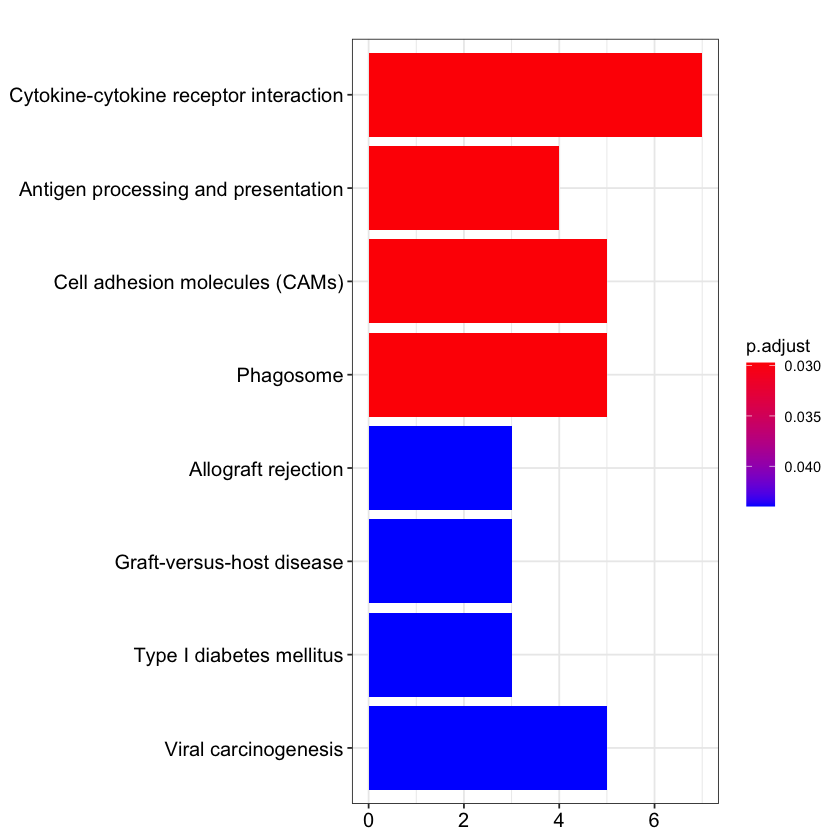

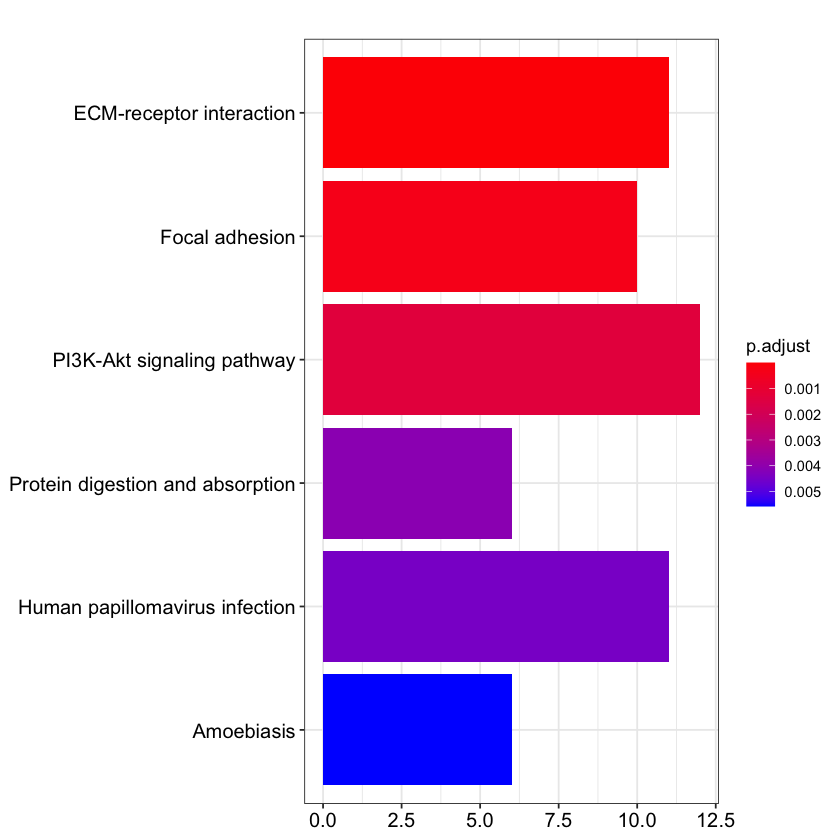

In [7]:
# upDEG
resKEGGUp <- enrichKEGG(entrezListUp, organism = "mmu")
barplot(resKEGGUp, showCategory = 10)

# downDEG
resKEGGDown <- enrichKEGG(entrezListDown, organism = "mmu")
barplot(resKEGGDown, showCategory = 10)

### 2-3-2. dotplot

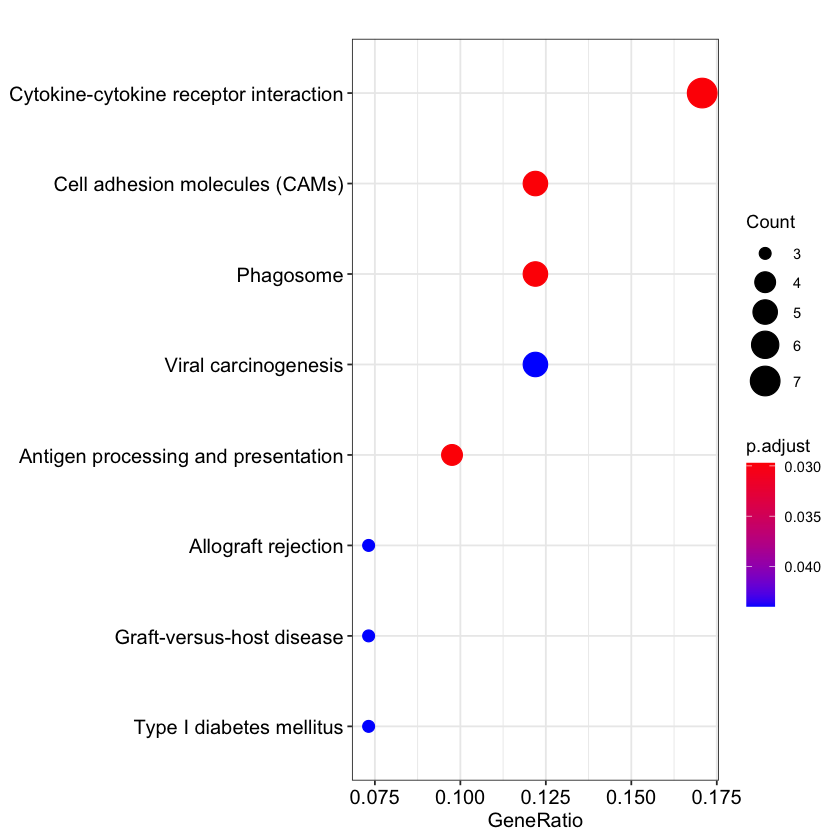

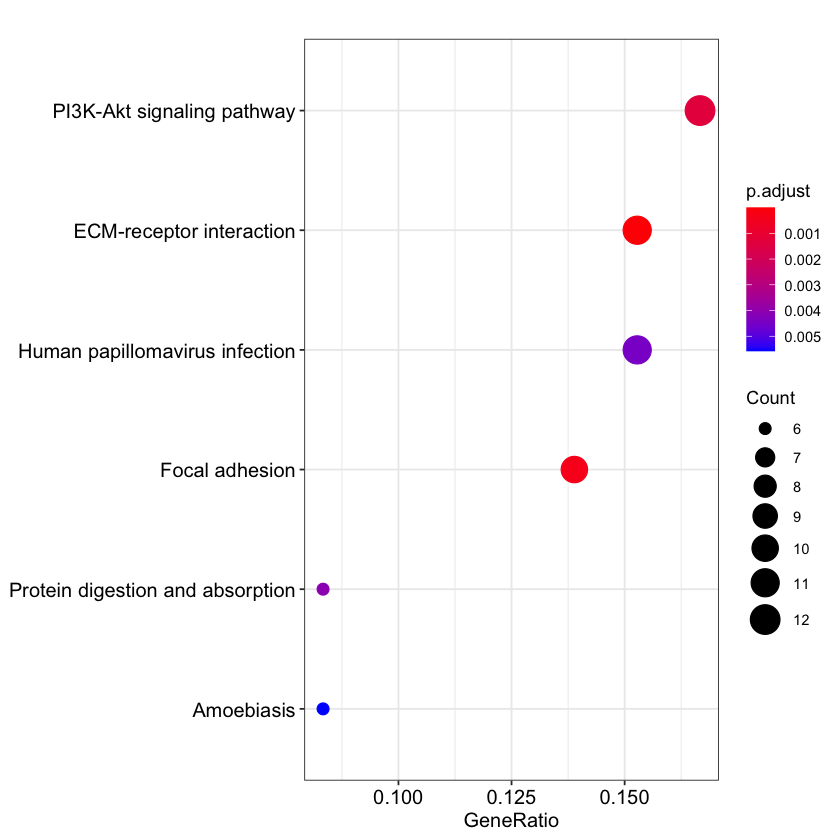

In [8]:
dotplot(resKEGGUp, showCategory = 10)
dotplot(resKEGGDown, showCategory = 10)

### 2-3-3. gene-concept network 

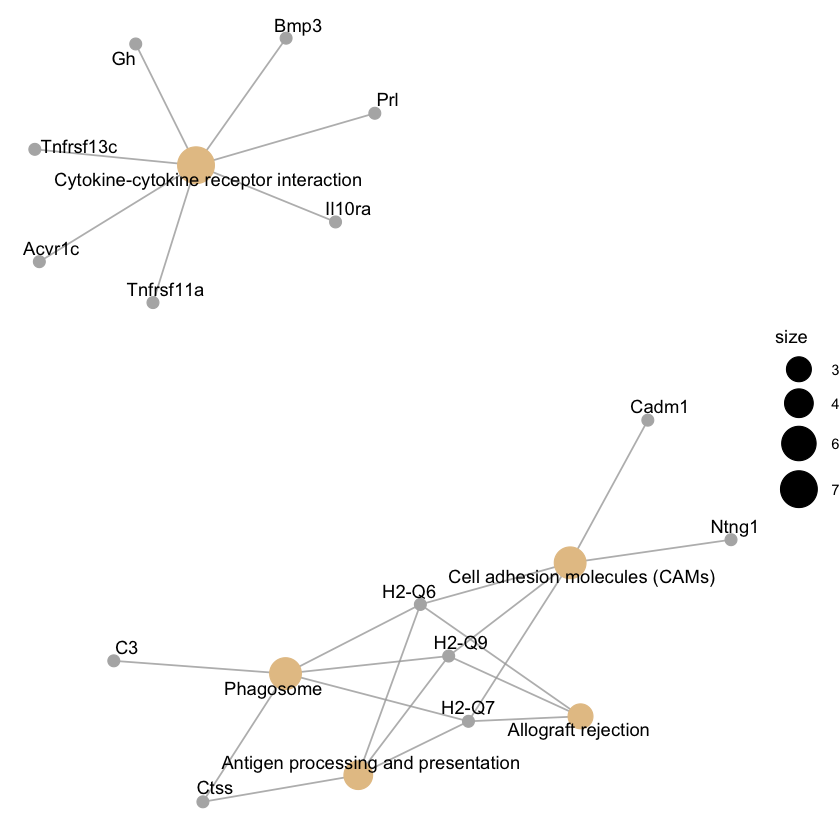

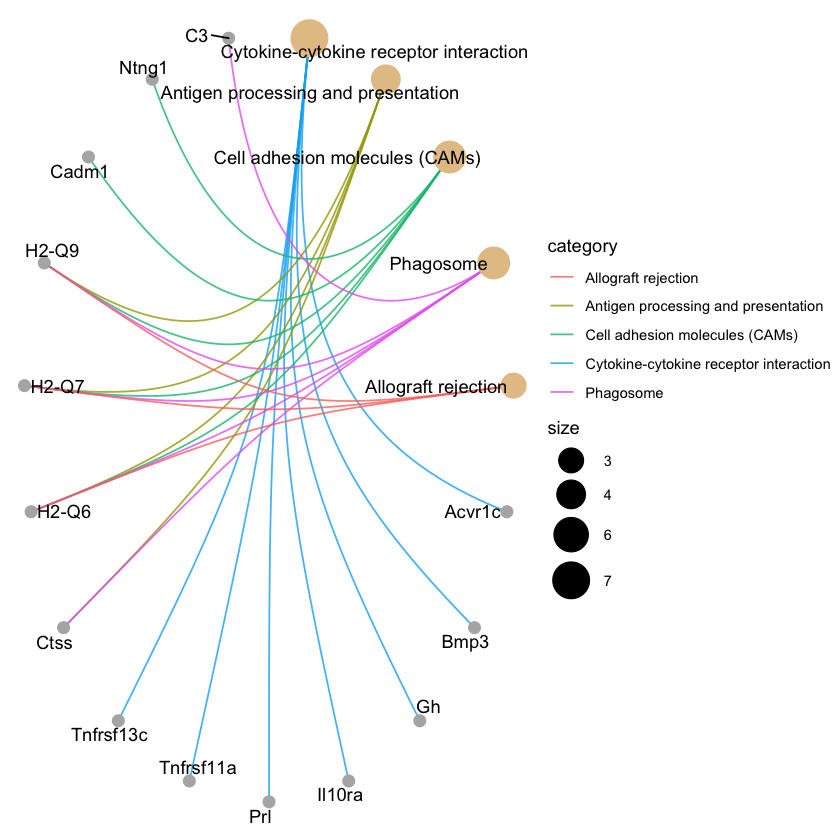

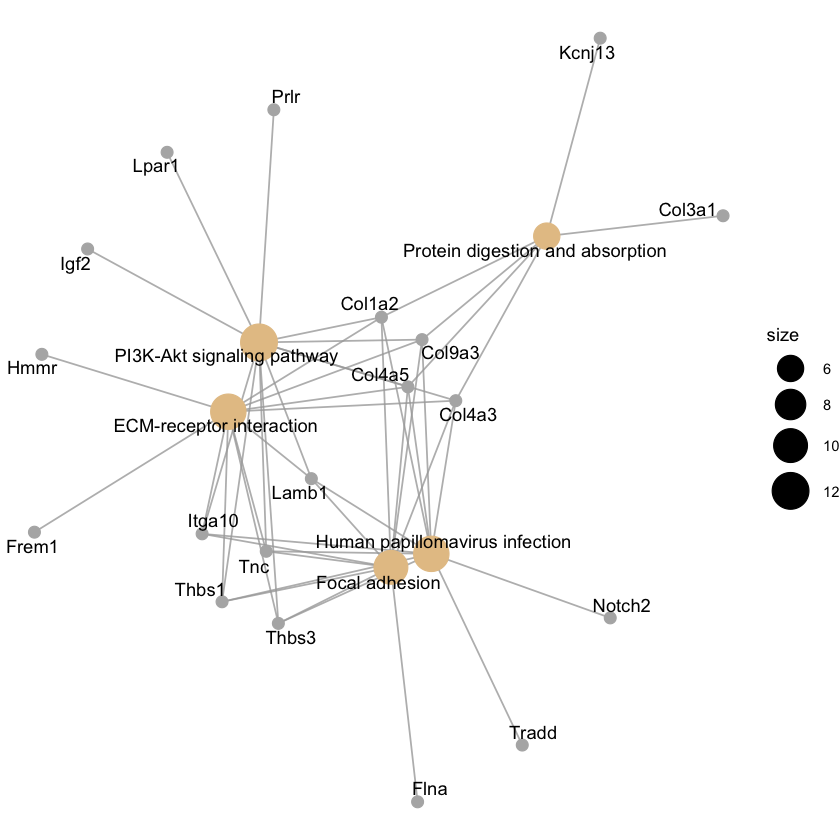

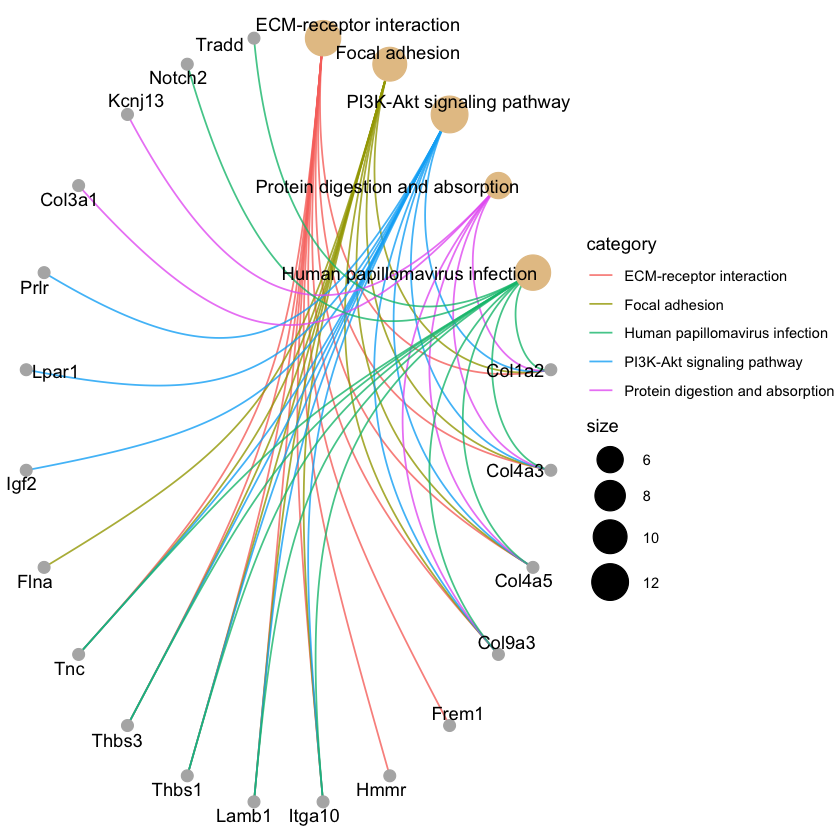

In [9]:
resKEGGEntrezUp <- setReadable(resKEGGUp, 'org.Mm.eg.db', 'ENTREZID')
p1 <- cnetplot(resKEGGEntrezUp, node_label="all") #foldChangeを色で反映させることができない
plot(p1)
p2 <- cnetplot(resKEGGEntrezUp, circular = TRUE, colorEdge = TRUE)
plot(p2)

resKEGGEntrezDown <- setReadable(resKEGGDown, 'org.Mm.eg.db', 'ENTREZID')
p3 <- cnetplot(resKEGGEntrezDown, node_label="all") #foldChangeを色で反映させることができない
plot(p3)
p4 <- cnetplot(resKEGGEntrezDown, circular = TRUE, colorEdge = TRUE)
plot(p4)

### 2-3-4. enrichment map

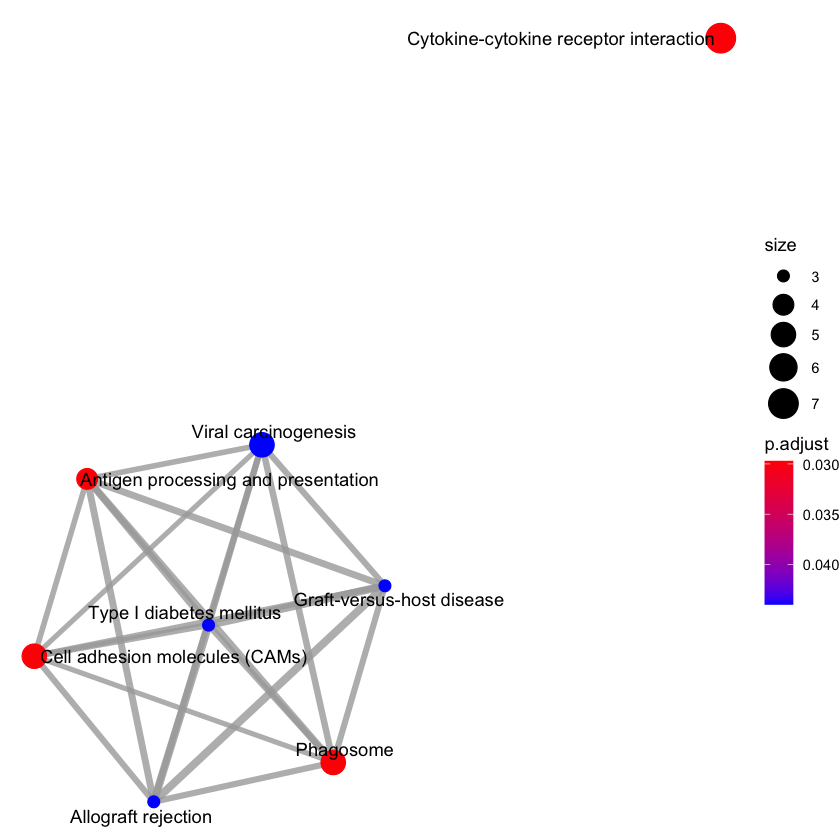

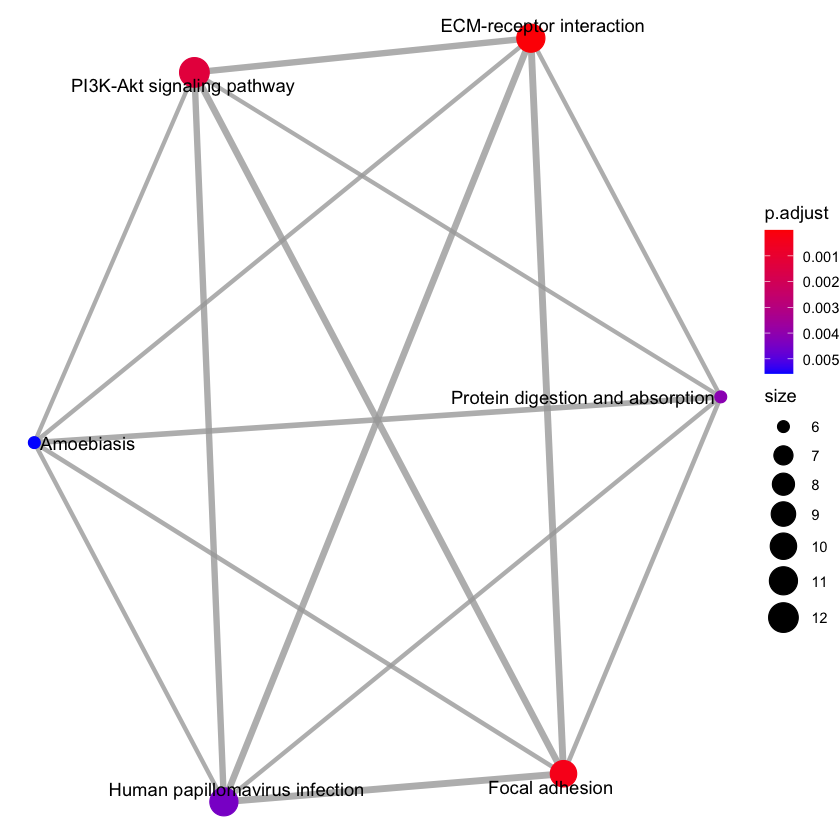

In [10]:
p5 <- emapplot(resKEGGEntrezUp)
plot(p5)

p6 <- emapplot(resKEGGEntrezDown)
plot(p6)